An example notebook retreiving a sample of nine paintings via Wikidata from the Bavarian State Painting Collection. Here is the SPARQL query used in the Code section below. [https://w.wiki/6VCz](https://w.wiki/6VCz). 

The notebooks is a sample 9 paintings from the Baroque period.

The complete collection is here on [Wikidata](https://www.wikidata.org/wiki/Wikidata:WikiProject_sum_of_all_paintings/Collection/Bavarian_State_Painting_Collections).

The below Python code uses SPARQLWrapper to retrieve data from Wikidata based on a SPARQL query.

Wikidata link: [http://www.wikidata.org/entity/Q29474642](http://www.wikidata.org/entity/Q29474642)

Title: The Birth of Benjamin

Year: 1650

Creator: Francesco Furini

Copyright: public domain



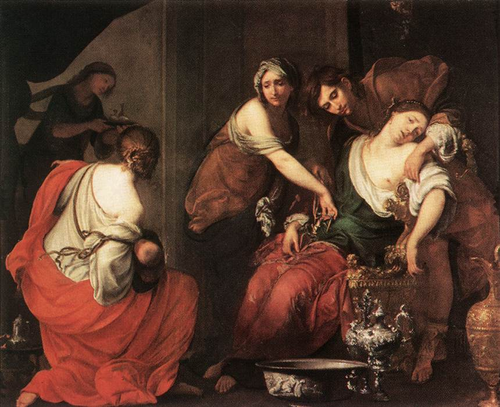




Wikidata link: [http://www.wikidata.org/entity/Q29474649](http://www.wikidata.org/entity/Q29474649)

Title: A Cynical Philosopher

Year: 1650

Creator: Luca Giordano

Copyright: public domain



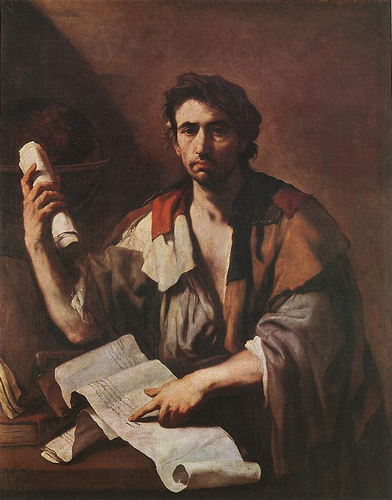




Wikidata link: [http://www.wikidata.org/entity/Q29474651](http://www.wikidata.org/entity/Q29474651)

Title: Solomon and the Queen of Sheba

Year: 1697

Creator: Luca Giordano

Copyright: public domain



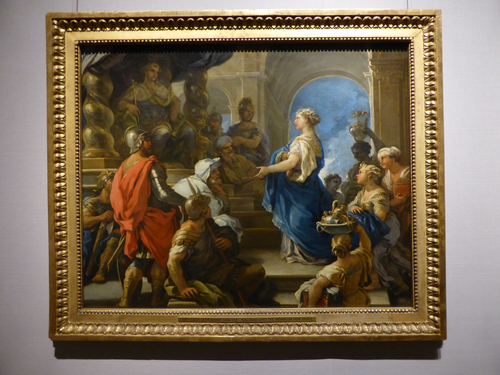




Wikidata link: [http://www.wikidata.org/entity/Q29477235](http://www.wikidata.org/entity/Q29477235)

Title: Q29477235

Year: 1674

Creator: Antonio Triva

Copyright: public domain



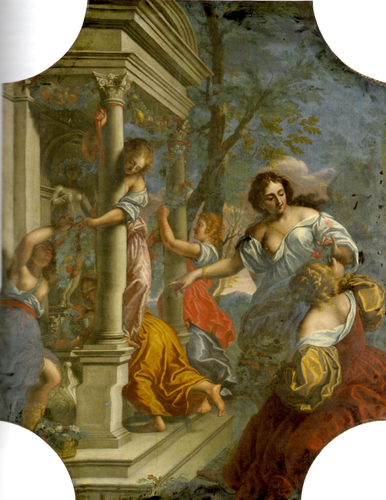




Wikidata link: [http://www.wikidata.org/entity/Q29477863](http://www.wikidata.org/entity/Q29477863)

Title: Q29477863

Year: 1633

Creator: Guido Reni

Copyright: public domain



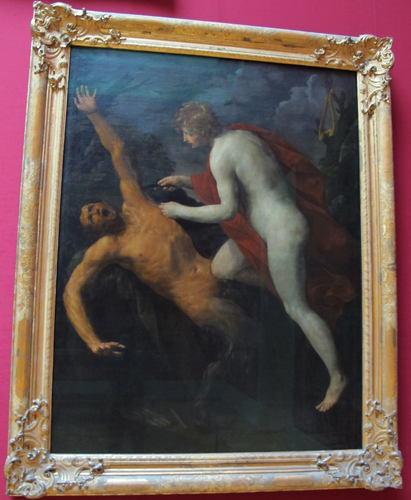




Wikidata link: [http://www.wikidata.org/entity/Q29477898](http://www.wikidata.org/entity/Q29477898)

Title: Still-Life with Books

Year: 1628

Creator: Jan Lievens

Copyright: public domain



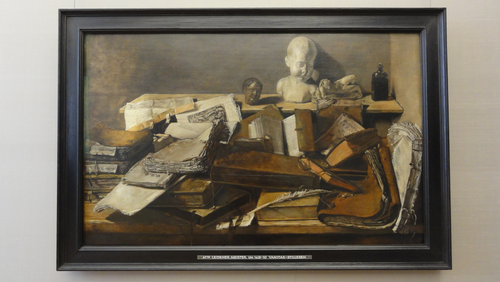




Wikidata link: [http://www.wikidata.org/entity/Q29480557](http://www.wikidata.org/entity/Q29480557)

Title: Feast of Herod

Year: 1630

Creator: http://www.wikidata.org/.well-known/genid/3f945710e81609ba4bae458b2820460a

Copyright: public domain



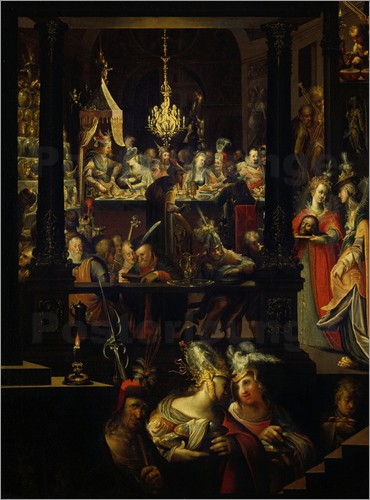




Wikidata link: [http://www.wikidata.org/entity/Q29480565](http://www.wikidata.org/entity/Q29480565)

Title: Venus and Cupid

Year: 1625

Creator: Heinrich Bollandt

Copyright: public domain



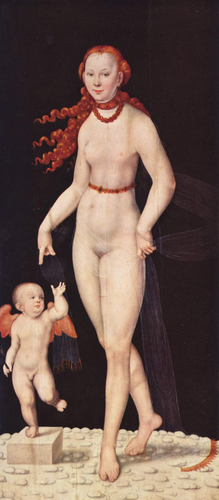




Wikidata link: [http://www.wikidata.org/entity/Q29480594](http://www.wikidata.org/entity/Q29480594)

Title: Still-life with Parrot

Year: 1630

Creator: Georg Flegel

Copyright: public domain



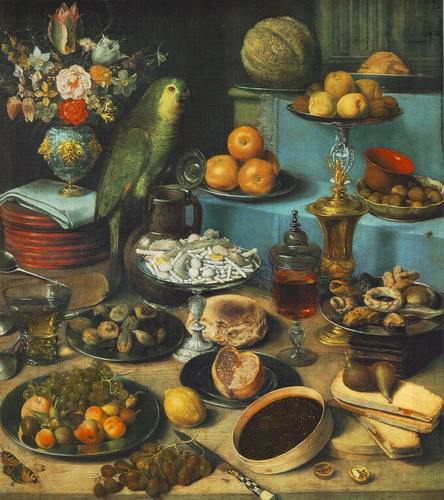

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
import requests

# VARIABLES

sparql_endpoint_url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
wikibase_url = 'https://www.wikidata.org'
api_url = '/w/api.php'

# Wikidata requires a user agent header to prevent spam requests
user_agent = 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'

# SPARQL query
# see in Wikidata's Query Service GUI at:
# https://w.wiki/6VCz
query = """
#defaultView:ImageGrid
SELECT ?item ?itemLabel ?inceptionyear ?creator ?creatorLabel ?copyright ?copyrightLabel ?image
WHERE
{
  # find items which:
  # are instances of (wdt:P31) paintings (wd:Q3305213)
  # have the property (wdt:P195) of being in collection wd:Q812285 (Bavarian State Painting Collections)
  ?item wdt:P31 wd:Q3305213 .
  ?item wdt:P195 wd:Q812285 .
  # get the item's creator property (wdt:P170)
  ?item wdt:P170 ?creator .
  # get the item's image property (wdt:P18)
  ?item wdt:P18 ?image .
  # get the item's copyright status (wdt:P6216)
  ?item wdt:P6216 ?copyright . 
  {
    ?item wdt:P571 ?inception.
    BIND(YEAR(?inception) AS ?inceptionyear)
  }

  # filter out all paintings not created between the years 1600 and 1700
  FILTER((1600  <= ?inceptionyear) && (?inceptionyear < 1700 ))
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } }
# limit to nine results
LIMIT 9
"""

# SUBROUTINES

def get_delay(date):
    try:
        date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
        timeout = int((date - datetime.datetime.now()).total_seconds())
    except ValueError:
        timeout = int(date)
    return timeout

def get_image(url, headers):
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        im = Image.open(r.raw)
        return im
    if r.status_code == 500:
        return None
    if r.status_code == 403:
        return None
    if r.status_code == 429:
        timeout = get_delay(r.headers['retry-after'])
        print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
        time.sleep(timeout)
        get_image(url, headers)

# MAIN PROGRAM

# create SPARQL query
sparql = SPARQLWrapper(sparql_endpoint_url, agent=user_agent)

# retrieve results and convert to JSON format
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
result = sparql.query().convert()

# for each result, print various data fields
for item in result['results']['bindings']:
    print('Wikidata link: ' + '[' + item['item']['value'] + ']' + '(' + item['item']['value'] + ')' + '\n')
    print('Title: ' + item['itemLabel']['value'] + '\n')
    print('Year: ' + item['inceptionyear']['value'] + '\n')
    print('Creator: ' + item['creatorLabel']['value'] + '\n')
    print('Copyright: ' + item['copyrightLabel']['value'] + '\n')

    # get image from image URL and display resized version
    image_url=item['image']['value']
    headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
    im = get_image(image_url, headers)
    im.thumbnail((500, 500), Image.Resampling.LANCZOS)
    display(im)
    print('\n\n')